In [48]:
import pandas as pd

df = pd.read_csv('versionInfo.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   filename                                      8 non-null      object
 1   version                                       8 non-null      object
 2   url                                           8 non-null      object
 3   description                                   8 non-null      object
 4   Type                                          8 non-null      object
 5   Associations with external schemes            8 non-null      object
 6   Available associations with external schemes  5 non-null      object
 7   Presence of controls/metrics                  8 non-null      object
 8   Number of controls/metrics                    8 non-null      int64 
 9   Association with old test data                3 non-null      object
 10  Associ

In [49]:
# Lista delle colonne da mantenere
cols_to_keep = [
    'filename',
    'Type',
    'Available associations with external schemes',
    'Number of controls/metrics',
    'Association with old test data',
    'Association with new training data'
]

# Crea il nuovo dataframe filtrato
df = df[cols_to_keep]


df

,filename,Type,Available associations with external schemes,Number of controls/metrics,Association with old test data,Association with new training data
0,Cisco.csv,Controls,"SpanishENS.csv, NewEucsRequirements.csv, secnu...",713,NaN,"SpanishENS.csv, NewEucsRequirements.csv, secnu..."
1,NewEucsRequirements.csv,Controls,"BSI-C5.json, secnumcloud_controlsParsedAndTran...",120,BSI-C5.json,secnumcloud_controlsParsedAndTranslatedEnglish...
2,SpanishENS.csv,Controls,NaN,209,NaN,NaN
3,BSI-C5.json,Controls,OldEucsRequirements.csv,294,OldEucsRequirements.csv,NaN
4,secnumcloud_controlsParsedAndTranslatedEnglish...,Controls,NaN,287,NaN,NaN
5,medinaMetrics.csv,Metrics,OldEucsRequirements.csv,166,OldEucsRequirements.csv,NaN
6,OldEucsRequirements.csv,Controls,NaN,70,NaN,NaN
7,fabasoftMetrics.csv,Metrics,"OldEucsRequirements.csv, BSI-C5.json",57,NaN,"NewEucsRequirements.csv, BSI-C5.json"


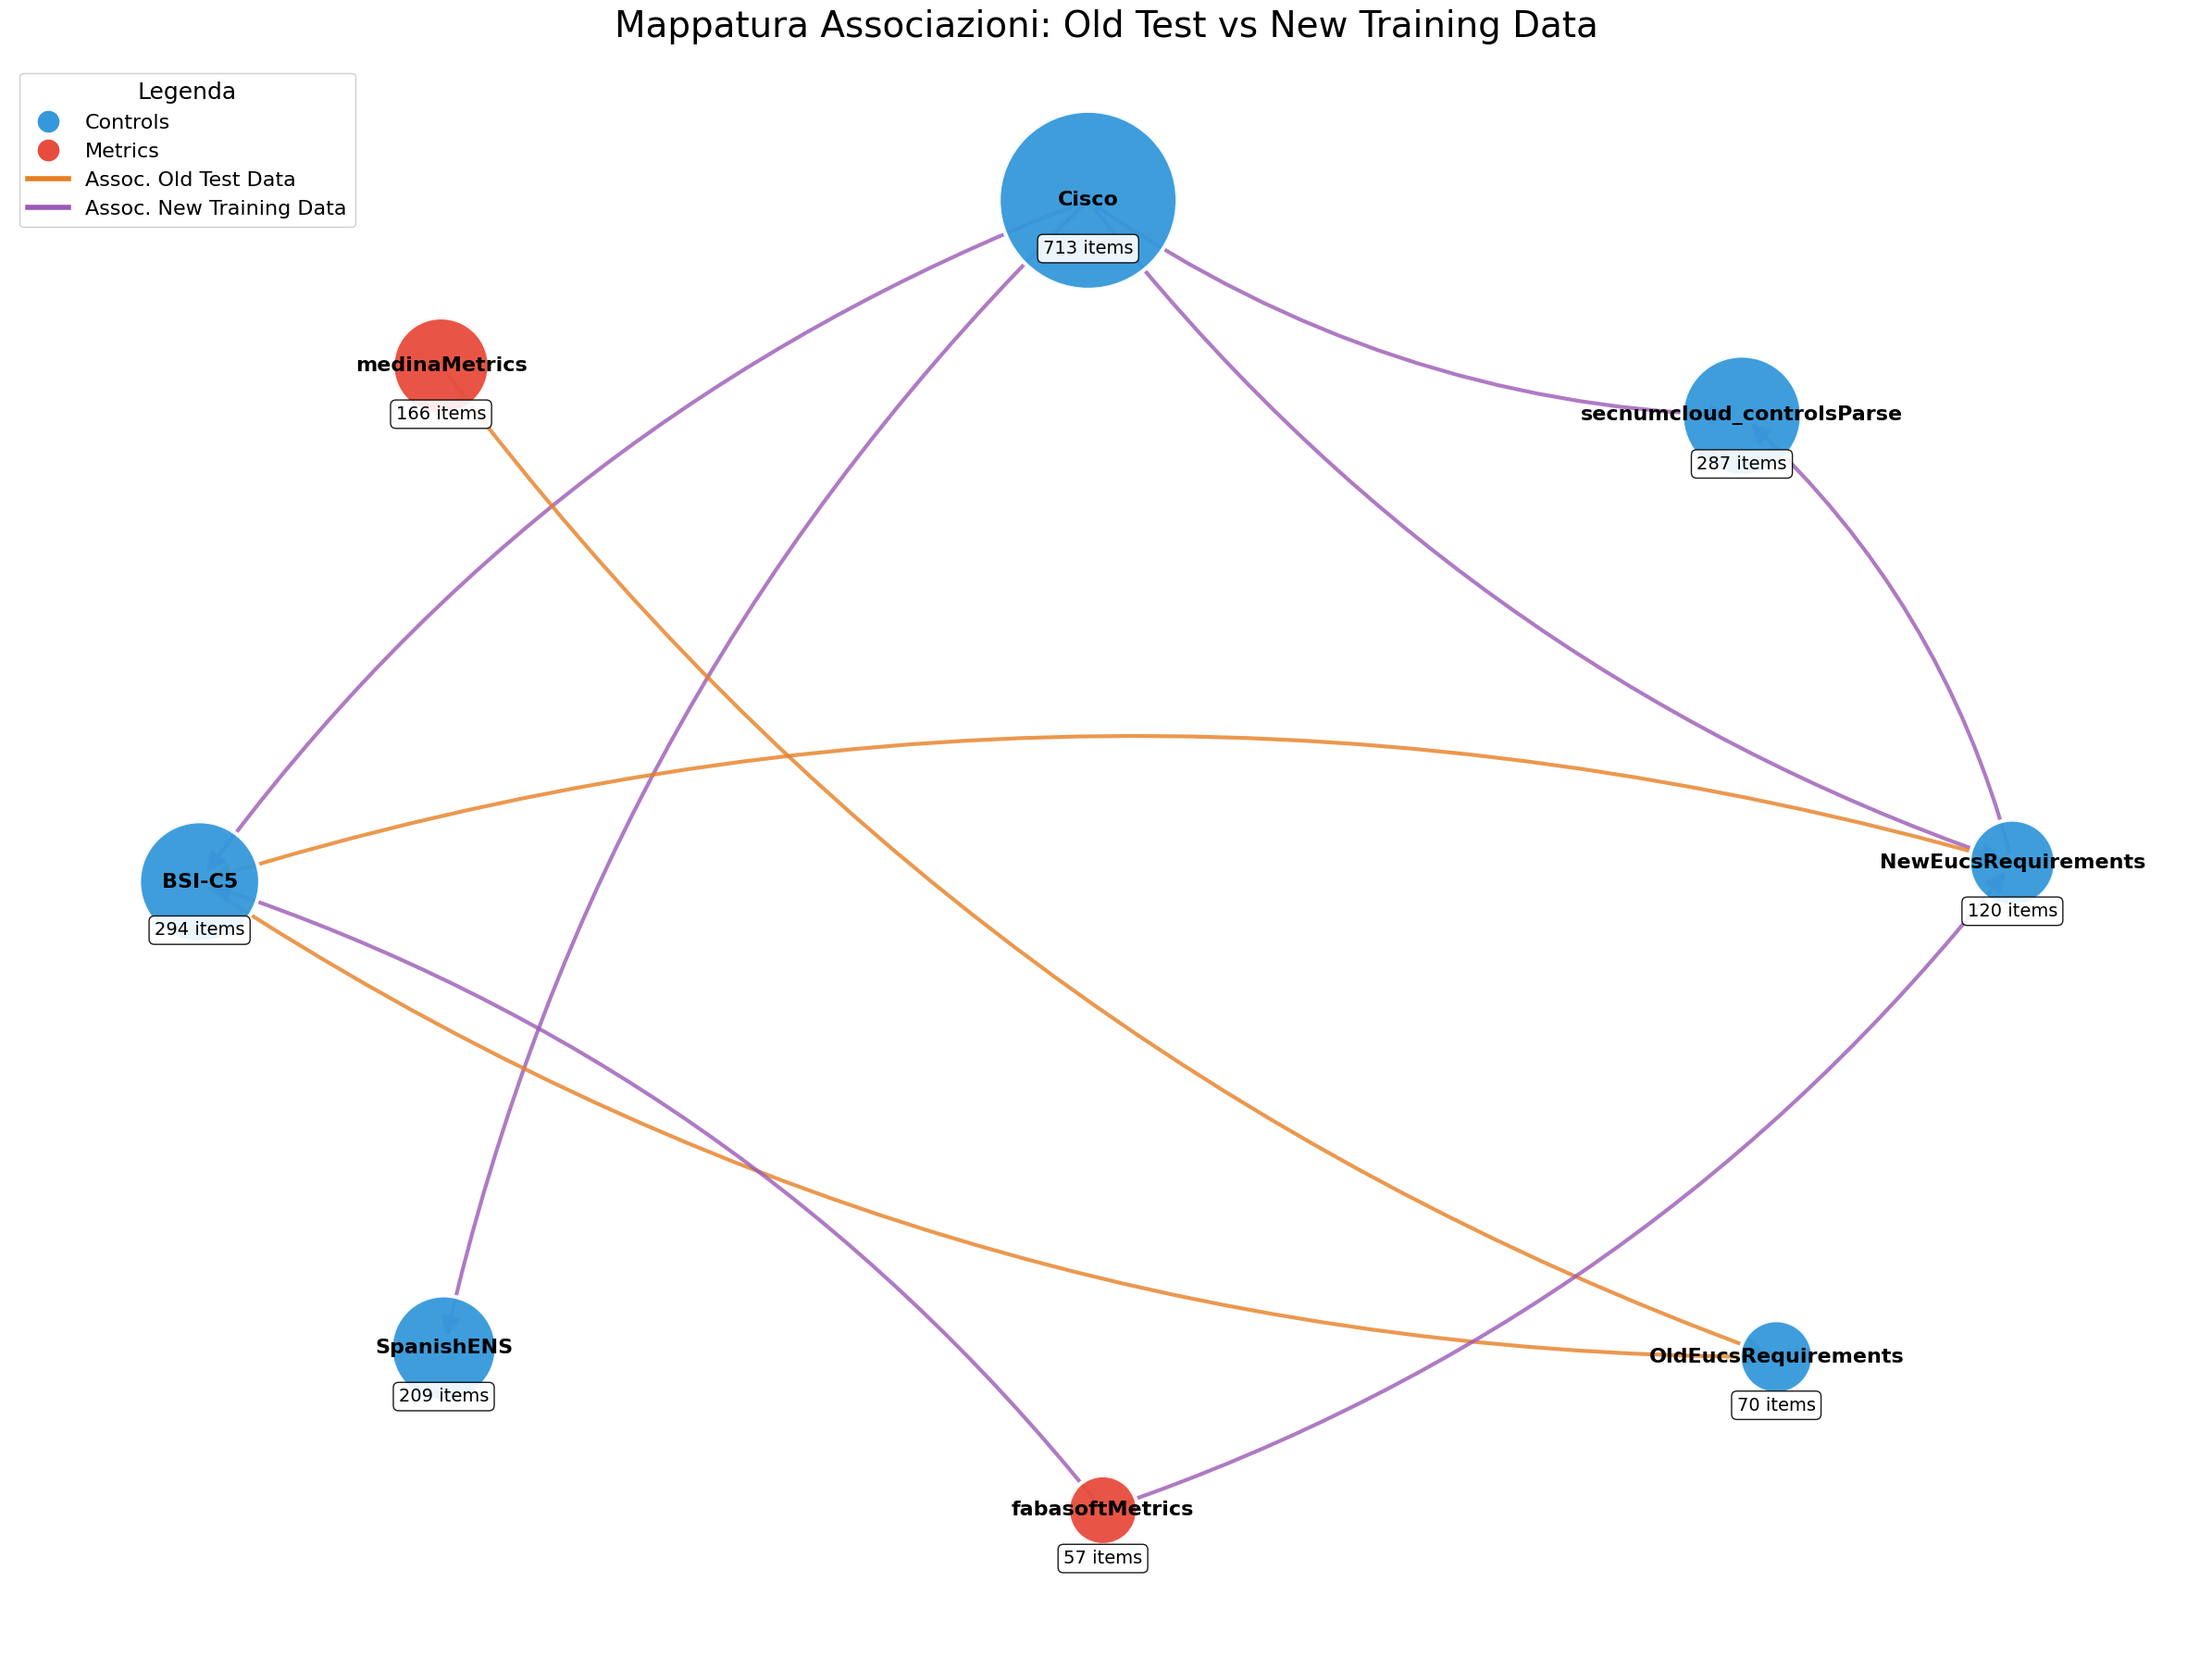

In [50]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

# Assumiamo che il tuo dataframe si chiami 'df'
df = df.fillna('')

G = nx.DiGraph()

# 1. AGGIUNTA DEI NODI
for idx, row in df.iterrows():
    filename = row['filename']
    node_type = row['Type']
    try:
        n_controls = int(row['Number of controls/metrics']) if row['Number of controls/metrics'] != '' else 10
    except:
        n_controls = 10
    
    G.add_node(filename, type=node_type, n_controls=n_controls)

# 2. AGGIUNTA DEGLI ARCHI
def add_edges_from_column(graph, dataframe, source_node, column_name, edge_color, edge_type_label):
    associations = dataframe.loc[dataframe['filename'] == source_node, column_name].values[0]
    if associations and str(associations).lower() != 'nan':
        target_list = [t.strip() for t in str(associations).split(',')]
        for target_partial_name in target_list:
            if not target_partial_name: continue
            matched_target = None
            for candidate in dataframe['filename']:
                if target_partial_name in candidate or candidate in target_partial_name:
                    matched_target = candidate
                    break
            if matched_target:
                if graph.has_edge(source_node, matched_target):
                    graph[source_node][matched_target]['color'] = '#2c3e50'
                    graph[source_node][matched_target]['type_label'] = 'Both'
                else:
                    graph.add_edge(source_node, matched_target, color=edge_color, type_label=edge_type_label)

for idx, row in df.iterrows():
    source = row['filename']
    add_edges_from_column(G, df, source, 'Association with old test data', '#e67e22', 'Old Test Data')
    add_edges_from_column(G, df, source, 'Association with new training data', '#9b59b6', 'New Train Data')

# 3. CONFIGURAZIONE VISUALIZZAZIONE
fig, ax = plt.subplots(figsize=(24, 18)) # Aumentata leggermente la dimensione della figura

# Layout: Aumentato k a 6 per dare più spazio ai testi grandi
pos = nx.spring_layout(G, k=6, iterations=100, seed=42)

color_map_nodes = {
    'Controls': '#3498db',
    'Metrics': '#e74c3c',
    'Requirements': '#2ecc71',
}
node_colors = [color_map_nodes.get(G.nodes[node].get('type', 'Other'), '#95a5a6') for node in G.nodes()]

# Dimensioni dei Nodi: Aumentata la base da 500 a 1500 per ospitare il testo
node_sizes = [G.nodes[node]['n_controls'] * 25 + 1500 for node in G.nodes()]

edge_colors = [G[u][v]['color'] for u, v in G.edges()]

# Disegna gli archi
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, 
                       arrowsize=30, arrowstyle='-|>', width=3, # Frecce più grandi e spesse
                       connectionstyle='arc3,rad=0.15', alpha=0.8, ax=ax)

# Disegna i nodi
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                       alpha=0.95, ax=ax, edgecolors='white', linewidths=3)

# --- MODIFICHE AI TESTI ---

# Etichette dei nodi: Font 16 (invece di 11)
labels = {node: node.replace('.csv', '').replace('.json', '')[:25] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_weight='bold', ax=ax)

# Annotazioni: Font 14 (invece di 9) e offset aggiustato
for node, (x, y) in pos.items():
    info = G.nodes[node]
    text = f"{info['n_controls']} items"
    # Spostato un po' più in basso (y-0.08) perché i nodi sono più grandi
    ax.text(x, y-0.08, text, fontsize=14, ha='center', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

# 4. LEGENDA
legend_nodes = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=18, label='Controls'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=18, label='Metrics'),
]

legend_edges = [
    plt.Line2D([0], [0], color='#e67e22', lw=4, label='Assoc. Old Test Data'),
    plt.Line2D([0], [0], color='#9b59b6', lw=4, label='Assoc. New Training Data'),
]

# Legenda: Font 16 e titolo 18
ax.legend(handles=legend_nodes + legend_edges, loc='upper left', 
          fontsize=16, title_fontsize=18, framealpha=0.95, title="Legenda")

ax.axis('off')
# Titolo: Font 28
plt.title("Mappatura Associazioni: Old Test vs New Training Data", fontsize=28, pad=20)
plt.tight_layout()
plt.show()